<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/UnetFold35e-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import os
batch_size=16

In [3]:
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, add, concatenate,UpSampling2D,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

In [4]:
train_img_path = "/gdrive/MyDrive/FOLD3/train/train_images"
train_mask_path = "/gdrive/MyDrive/FOLD3/train/train_masks"

val_img_path = "/gdrive/MyDrive/FOLD3/train/val_images"
val_mask_path = "/gdrive/MyDrive/FOLD3/train/val_masks"

In [5]:
seed=42
from keras.preprocessing.image import ImageDataGenerator


img_data_gen_args = dict(rescale=1./255,
                     rotation_range=90,
                     brightness_range=[0.3,0.9],
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(
                     rotation_range=90,
                     brightness_range=[0.3,0.9],
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)
                     
                     ) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

In [32]:
image_generator = image_data_generator.flow_from_directory(train_img_path, 
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           color_mode = 'grayscale',
                                                           target_size=(256,256),
                                                           
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

mask_generator = mask_data_generator.flow_from_directory(train_mask_path, 
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',
                                                         target_size=(256,256)  , #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory(val_img_path, 
                                                               seed=seed, 
                                                               batch_size=597, 
                                                               color_mode = 'grayscale', 
                                                               target_size=(256,256),
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory(val_mask_path, 
                                                               seed=seed, 
                                                               batch_size=597, 
                                                               target_size=(256,256),
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

Found 2862 images belonging to 1 classes.
Found 2862 images belonging to 1 classes.
Found 597 images belonging to 1 classes.
Found 597 images belonging to 1 classes.


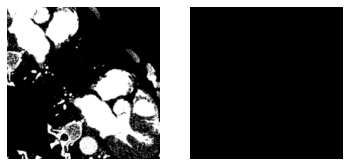

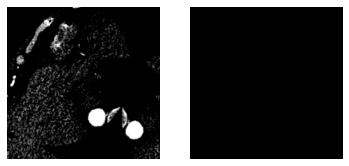

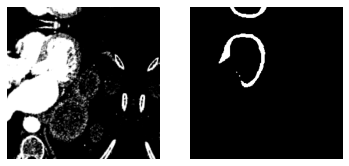

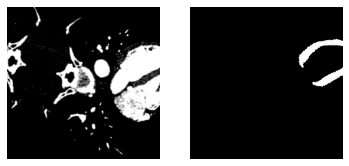

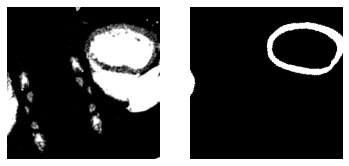

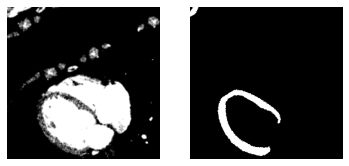

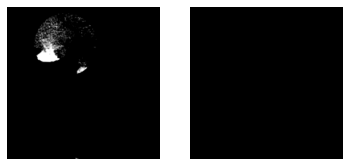

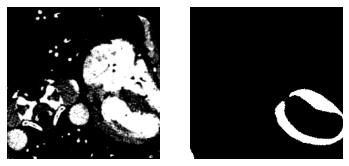

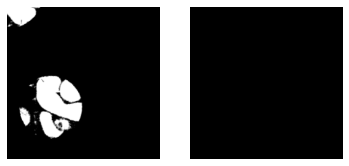

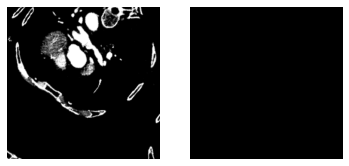

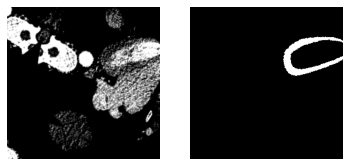

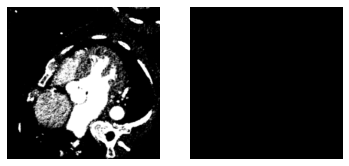

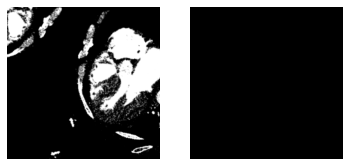

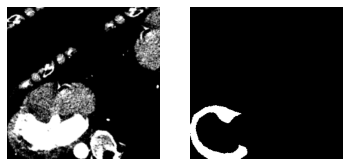

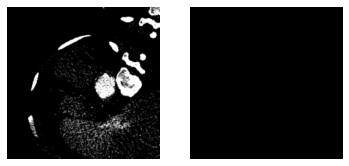

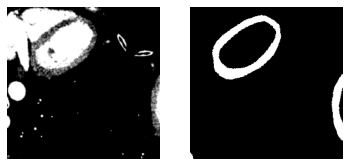

In [7]:
x, y = train_generator.__next__()

for i in range(0,16):
    image = x[i,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= y[i,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [8]:
x.max()

0.8352942

In [9]:
y.max()

1.0

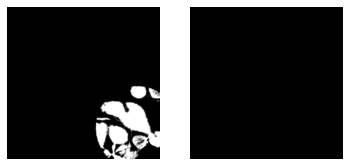

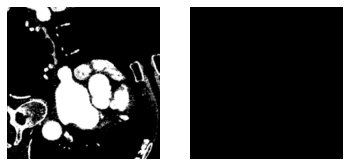

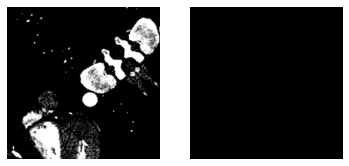

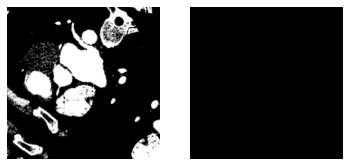

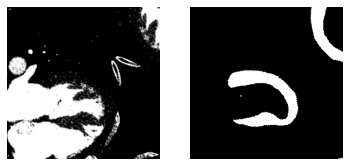

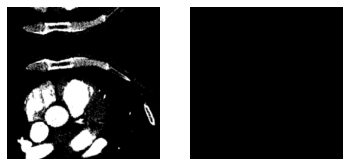

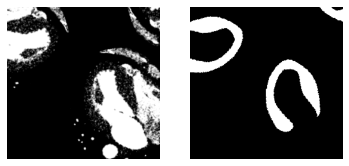

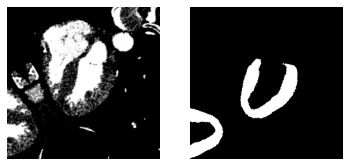

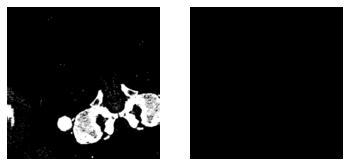

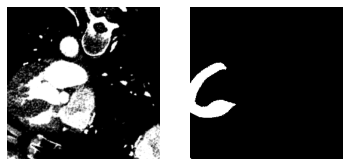

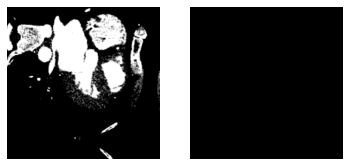

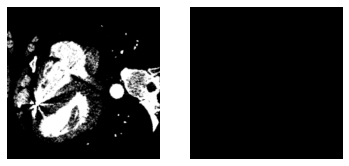

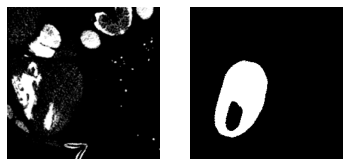

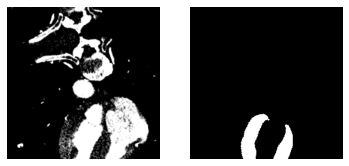

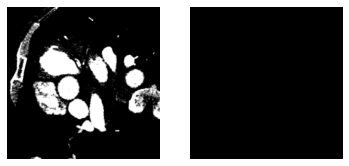

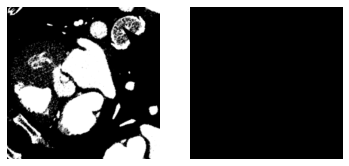

In [10]:
x, y = val_generator.__next__()

for i in range(0,16):
    image = x[i,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= y[i,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [11]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/gdrive/MyDrive/FOLD3/train/train_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/FOLD3/train/val_images/images'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(256, 256, 1)


In [12]:
print(steps_per_epoch)

178


In [13]:
print(val_steps_per_epoch)

37


In [14]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1= tf.keras.layers.BatchNormalization()(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1= tf.keras.layers.BatchNormalization()(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2= tf.keras.layers.BatchNormalization()(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2= tf.keras.layers.BatchNormalization()(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3= tf.keras.layers.BatchNormalization()(c3)

c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3= tf.keras.layers.BatchNormalization()(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4= tf.keras.layers.BatchNormalization()(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4= tf.keras.layers.BatchNormalization()(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5= tf.keras.layers.BatchNormalization()(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5= tf.keras.layers.BatchNormalization()(c5)
#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [15]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [16]:
from keras import backend as K


def dice_coefficient(y_true, y_pred, smooth=0.0001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return ((2. * intersection + smooth) / (K.sum(y_true_f) +
            K.sum(y_pred_f) + smooth))


def dice_coefficient_loss(y_true, y_pred):
    return 1.0-dice_coefficient(y_true, y_pred)


def iou_loss(y_true, y_pred):
    return 1-iou(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.square(y_true)) + K.sum(K.square(y_pred))
    jac = (intersection) / (sum_ - intersection)
    return jac

In [17]:
LR = 5e-5
optim = tf.keras.optimizers.Adam(LR)

In [18]:
metrics=[iou, dice_coefficient, 'binary_accuracy']

In [19]:
model.compile(optimizer=optim, loss=dice_coefficient_loss, metrics=metrics)


In [20]:
history=model.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
      
          validation_data=val_generator,
          validation_steps=val_steps_per_epoch)

Epoch 1/50
178/178 [==============================] - 773s 4s/step - loss: 0.8190 - iou: 0.1354 - dice_coefficient: 0.1812 - binary_accuracy: 0.6980 - val_loss: 0.7405 - val_iou: 0.1641 - val_dice_coefficient: 0.2547 - val_binary_accuracy: 0.9234
Epoch 2/50
178/178 [==============================] - 53s 299ms/step - loss: 0.4882 - iou: 0.3611 - dice_coefficient: 0.5118 - binary_accuracy: 0.9727 - val_loss: 0.6942 - val_iou: 0.1894 - val_dice_coefficient: 0.3044 - val_binary_accuracy: 0.9165
Epoch 3/50
178/178 [==============================] - 53s 300ms/step - loss: 0.4405 - iou: 0.4043 - dice_coefficient: 0.5592 - binary_accuracy: 0.9759 - val_loss: 0.5878 - val_iou: 0.2728 - val_dice_coefficient: 0.4120 - val_binary_accuracy: 0.9426
Epoch 4/50
178/178 [==============================] - 53s 299ms/step - loss: 0.4133 - iou: 0.4309 - dice_coefficient: 0.5867 - binary_accuracy: 0.9773 - val_loss: 0.5085 - val_iou: 0.3420 - val_dice_coefficient: 0.4897 - val_binary_accuracy: 0.9637
Epoch 

In [21]:
model.save('/gdrive/MyDrive/FOLD3/model/UnetFold3preprocessingfunction.h5')

In [22]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/FOLD3/model/UnetFold3preprocessingfunction.h5", compile=False)

In [33]:
a, b = val_generator.__next__()


In [34]:
a.shape[0]

597

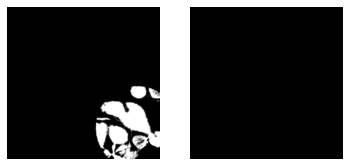

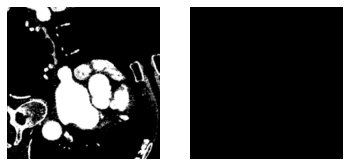

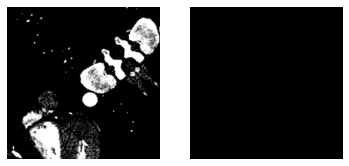

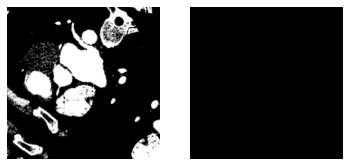

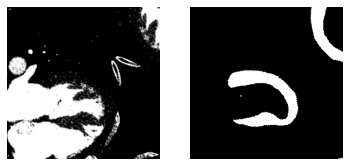

In [35]:
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(mask[:,:,0],cmap='gray')
    plt.show()

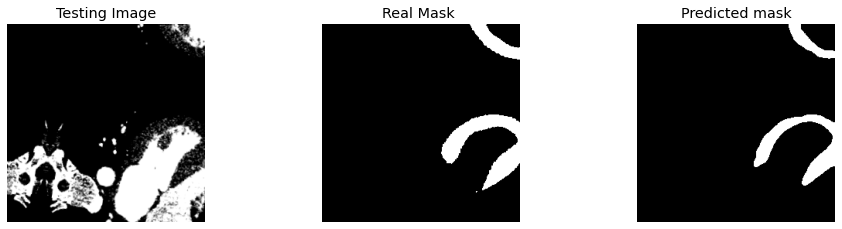

In [60]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.axis('off')
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')


plt.subplot(232)
plt.title('Real Mask ')
plt.axis('off')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.axis('off')
plt.title('Predicted mask')
plt.imshow(prediction, cmap='gray')

plt.show()

In [56]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  

IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 1.0


In [42]:
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

1.0
1.0
1.0
1.0
0.8440292
1.0
0.8440627
0.81727266
0.49311066
0.8356633
1.0
0.46985626
0.5817989
0.8789255
1.0
0.49967194
0.85567296
1.0
0.8604217
1.0
0.87547493
0.84358454
0.44860077
0.9248831
1.0
0.8893373
1.0
1.0
0.491745
1.0
0.9189613
1.0
1.0
0.49874878
1.0
0.8307884
1.0
0.4948349
1.0
0.842674
0.48582458
0.80064297
1.0
0.82705206
0.84100354
0.8971878
0.4932022
1.0
1.0
0.87241924
0.89313626
1.0
1.0
0.49637604
0.8315528
1.0
0.880208
0.49887085
0.48812103
0.49552155
1.0
0.48745728
1.0
1.0
0.8896761
1.0
0.48226166
0.4837799
0.49998474
1.0
1.0
0.8938396
0.84437907
0.83920556
1.0
0.90099084
1.0
1.0
1.0
0.47135162
1.0
1.0
0.49985504
0.69784635
1.0
0.7784722
1.0
0.8470932
0.78797984
0.79378396
0.49090576
0.7193316
1.0
0.7760411
1.0
1.0
0.7133364
0.88648415
0.8306637
1.0
1.0
1.0
1.0
0.49996185
1.0
0.4953308
1.0
1.0
0.49654388
0.49697113
0.4561386
0.49118042
1.0
0.48480988
0.8797009
1.0
0.49031067
0.8973602
0.47496033
0.8130735
0.8610307
0.49256134
1.0
0.4964981
0.7434853
0.48552704
0.498718